In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval

# Pre-processing of data

In [2]:
def pre_process_input_data(dataframe):
    '''
    dataframe must be pandas dataFrame with appropiate columns...
    '''
    
    dataframe.rename(columns={'Unnamed: 0':'frame'}, inplace=True)

    # convert columns with literal_eval to not have strings anymore
    dataframe.player_pos = dataframe.player_pos.apply(lambda row: literal_eval(row))
    dataframe.visible_obstacles = dataframe.visible_obstacles.apply(lambda row : literal_eval(row))
    dataframe.visible_drift_tiles = dataframe.visible_drift_tiles.apply(lambda row : literal_eval(row))
    
    # adjust time tag
    dataframe['adjusted_time_tag'] = dataframe.time_played + dataframe.time_tag

    ## annotate input data
    
    # input can be either None, "Right", "Left"
    rows_with_input = dataframe[~dataframe["current_input"].isnull()][["frame"]]
    # subsetting columns
    
    # condition for start input
    cond = rows_with_input.frame - rows_with_input.frame.shift(1) >= 2

    # have =1 everywhere condition applies and =0 where not
    rows_with_input["start_input"] = np.where(cond, 1, 0)

    # flag first row also as start input (because we missed it by not taking any rows before that row due to subsetting)
    index = rows_with_input.iloc[0].frame
    rows_with_input.loc[index, "start_input"] = 1.0

    # label all frames of each individual input with number of input
    rows_with_input["N_input"] = (rows_with_input["start_input"] == 1).cumsum()
    
    # joining dataframes
    dataframe = dataframe.merge(rows_with_input, on="frame", how='left')

    ## annotate input switch (strategy change?)
    rows_with_input_direction = dataframe[dataframe["start_input"] == 1][["frame", "current_input"]]

    # condition for input switch
    cond = rows_with_input_direction.current_input != rows_with_input_direction.current_input.shift(1)

    # have =1 everywhere condition applies and =0 where not
    rows_with_input_direction["input_change"] = np.where(cond, 1, 0)
    # drop current_input column for better merge in next step
    rows_with_input_direction.drop(columns="current_input", axis=1, inplace=True)
    
    # joining dataframes
    dataframe = dataframe.merge(rows_with_input_direction, on="frame", how='left')
    
    return dataframe

In [3]:
data = pd.read_csv('input_data/pilot4_output_04.csv', index_col=False)
data = pre_process_input_data(data)
data

,frame,trial,attempt,time_played,time_tag,level_size_y,player_pos,collision,current_input,drift_enabled,...,input_noise_magnitude,input_noise_on,visible_obstacles,adjacent_wall_tiles_x_pos,visible_drift_tiles,SoC,adjusted_time_tag,start_input,N_input,input_change
0,0,5,1,0.000998,2969.977121,9018,"[954, -86]",False,NaN,True,...,NaN,False,[],NaN,[],NaN,2969.978118,NaN,NaN,NaN
1,1,5,1,0.017058,2969.977121,9018,"[954, -82]",False,NaN,True,...,NaN,False,[],NaN,[],NaN,2969.994179,NaN,NaN,NaN
2,2,5,1,0.033623,2969.977121,9018,"[954, -78]",False,NaN,True,...,NaN,False,[],NaN,[],NaN,2970.010743,NaN,NaN,NaN
3,3,5,1,0.049330,2969.977121,9018,"[954, -74]",False,NaN,True,...,NaN,False,[],NaN,[],NaN,2970.026451,NaN,NaN,NaN
4,4,5,1,0.066156,2969.977121,9018,"[954, -70]",False,NaN,True,...,NaN,False,[],NaN,[],NaN,2970.043276,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,1544,5,1,26.968981,2969.977121,9018,"[954, 270]",False,NaN,True,...,NaN,True,[],NaN,[],NaN,2996.946102,NaN,NaN,NaN
1545,1545,5,1,26.985721,2969.977121,9018,"[954, 270]",False,NaN,True,...,NaN,True,[],NaN,[],NaN,2996.962841,NaN,NaN,NaN
1546,1546,5,1,27.001301,2969.977121,9018,"[954, 270]",False,NaN,True,...,NaN,True,[],NaN,[],NaN,2996.978421,NaN,NaN,NaN
1547,1547,5,1,27.022249,2969.977121,9018,"[954, 270]",False,NaN,True,...,NaN,True,[],NaN,[],NaN,2996.999370,NaN,NaN,NaN


In [4]:
#data.iloc[1000]
test = data[~data["current_input"].isnull()]
#test = data[data["start_input"] == 1.0]
test[:50]

,frame,trial,attempt,time_played,time_tag,level_size_y,player_pos,collision,current_input,drift_enabled,...,input_noise_magnitude,input_noise_on,visible_obstacles,adjacent_wall_tiles_x_pos,visible_drift_tiles,SoC,adjusted_time_tag,start_input,N_input,input_change
102,102,5,1,1.673372,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.650492,1.0,1.0,1.0
103,103,5,1,1.689922,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.667043,0.0,1.0,NaN
104,104,5,1,1.705778,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.682899,0.0,1.0,NaN
105,105,5,1,1.721974,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.699094,0.0,1.0,NaN
106,106,5,1,1.737821,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.714942,0.0,1.0,NaN
107,107,5,1,1.753994,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.731115,0.0,1.0,NaN
108,108,5,1,1.770770,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.747891,0.0,1.0,NaN
109,109,5,1,1.786702,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.763823,0.0,1.0,NaN
110,110,5,1,1.802828,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.779948,0.0,1.0,NaN
111,111,5,1,1.818786,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.795906,0.0,1.0,NaN


## Variables of interest

In [5]:
seconds_played = data.iloc[-2].time_played  # second last row because last row is written to df AFTER SoC response given which may take time
seconds_played

27.02224898338318

In [6]:
SoC = data.iloc[-1].SoC
SoC

6.0

In [7]:
crashed = data.iloc[-1].collision
crashed

False

# Eye-tracking data

In [43]:
def calc_saccade_direction(saccade_rows):
    '''
    Need to be given pandas dataframe grouped by N_saccade. 
    Dataframe must have columns of eye positions (e.g. LeftEyeX) and saccade_direction.
    Returned dataframe now holds direction vector of saccade in every row in column saccade direction.
    '''

    # x-direction
    left_eye_x_direction = saccade_rows.iloc[-1].LeftEyeX - saccade_rows.iloc[0].LeftEyeX
    right_eye_x_direction = saccade_rows.iloc[-1].RightEyeX - saccade_rows.iloc[0].RightEyeX
    x_direction = (left_eye_x_direction + right_eye_x_direction)/2
    
    # y-direction
    left_eye_y_direction = saccade_rows.iloc[-1].LeftEyeY - saccade_rows.iloc[0].LeftEyeY
    right_eye_y_direction = saccade_rows.iloc[-1].RightEyeY - saccade_rows.iloc[0].RightEyeY
    y_direction = (left_eye_y_direction + right_eye_y_direction)/2
    
    saccade_rows.saccade_direction = saccade_rows.apply(lambda x: [x_direction, y_direction], axis=1)
    
    return saccade_rows

In [44]:
# annotate eye_tracking data

def pre_process_eye_data(eye_data):
    
    # adjust time tag to start at 0
    eye_data["time_tag"] = eye_data.TimeTag - eye_data.TimeTag[0]
    
    # annotate binocular fixations
    eye_data["Fixation"] = eye_data.LeftEyeFixationFlag + eye_data.RightEyeFixationFlag
    ## eliminate simultaneous blink and fixation (setting fixation to 0)
    eye_data.Fixation.loc[eye_data.LeftBlink > 0.0] = 0.0
    eye_data.Fixation.loc[eye_data.RightBlink > 0.0] = 0.0
    eye_data.Fixation[eye_data.Fixation > 1] = 1.0
    
    # annotate binocular saccades
    eye_data["Saccade"] = eye_data.LeftEyeSaccadeFlag + eye_data.RightEyeSaccadeFlag
    ## eliminate simultaneous blink and saccades (setting saccade to 0)
    eye_data.Saccade.loc[eye_data.LeftBlink > 0.0] = 0.0
    eye_data.Saccade.loc[eye_data.RightBlink > 0.0] = 0.0
    eye_data.Saccade[eye_data.Saccade > 1] = 1.0
    
    # condition for initiating saccade
    cond = (eye_data.Saccade >= 1.0) & (eye_data.Saccade.shift(1) == 0.0)

    # have =1 everywhere condition applies and =0 where not
    eye_data["saccadeOnset"] = np.where(cond, 1, 0)
    
    # insert N_saccade - counting up saccades
    eye_data["N_saccade"] = (eye_data["saccadeOnset"] == 1).cumsum()
    eye_data.loc[eye_data.Saccade < 1.0, "N_saccade"] = np.nan  # have NaN everywhere where there is no saccade
    
    # insert saccade direction column
    eye_data["saccade_direction"] = np.nan
    eye_data.groupby("N_saccade").apply(calc_saccade_direction)
    
    return eye_data

## pilot 4 run 04

In [10]:
eye_data = pd.read_csv('eye_data/pilot4_eye_tracking_output_04.csv', index_col=False)
eye_data = pre_process_eye_data(eye_data)

In [11]:
saccade_directions = eye_data[~eye_data["saccade_direction"].isnull()]
saccade_directions

,TimeTag,LeftEyeX,LeftEyeY,LeftPupilDiameter,RightEyeX,RightEyeY,RightPupilDiameter,DigitalIn,LeftBlink,RightBlink,...,MessageCode,LeftEyeRawX,LeftEyeRawY,RightEyeRawX,RightEyeRawY,time_tag,Saccade,saccadeOnset,N_saccade,saccade_direction
256,2970.1045,-419.222229,-311.874268,55.871094,-506.637970,-335.133789,59.437500,16777215.0,0.0,0.0,...,0.0,8.052002,23.425781,1.445801,18.855713,0.1280,1.0,1,1.0,"[235.70210266113284, 177.94827270507812]"
257,2970.1050,-411.735291,-307.231018,55.953125,-502.365051,-332.145813,59.500000,16777215.0,0.0,0.0,...,0.0,8.229980,23.547119,1.550049,18.943115,0.1285,1.0,0,1.0,"[235.70210266113284, 177.94827270507812]"
258,2970.1055,-404.466431,-302.934631,56.015625,-497.758972,-329.640625,59.539062,16777215.0,0.0,0.0,...,0.0,8.402832,23.659912,1.662354,19.016602,0.1290,1.0,0,1.0,"[235.70210266113284, 177.94827270507812]"
259,2970.1060,-396.759827,-298.315430,56.074219,-492.936340,-327.012756,59.593750,16777215.0,0.0,0.0,...,0.0,8.586182,23.781250,1.780029,19.093750,0.1295,1.0,0,1.0,"[235.70210266113284, 177.94827270507812]"
260,2970.1065,-389.305634,-293.215576,56.121094,-488.628632,-323.660767,59.617188,16777215.0,0.0,0.0,...,0.0,8.763672,23.914307,1.885498,19.191895,0.1300,1.0,0,1.0,"[235.70210266113284, 177.94827270507812]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55012,2997.4825,55.477905,-3.501953,49.074219,180.364807,19.181458,51.207031,16777215.0,0.0,0.0,...,0.0,19.593018,31.939453,19.214844,30.345215,27.5060,1.0,0,15.0,"[43.222808837890625, -95.97360229492188]"
55013,2997.4830,63.784180,-17.665161,48.574219,186.176575,-0.376892,50.445312,16777215.0,0.0,0.0,...,0.0,19.786865,31.583984,19.304199,29.765381,27.5065,1.0,0,15.0,"[43.222808837890625, -95.97360229492188]"
55014,2997.4835,59.824890,-32.741211,47.285156,198.105591,-18.718567,49.617188,16777215.0,0.0,0.0,...,0.0,19.678223,31.179443,19.555420,29.242676,27.5070,1.0,0,15.0,"[43.222808837890625, -95.97360229492188]"
55015,2997.4840,56.804138,-46.865234,46.085938,206.034485,-38.285400,48.859375,16777215.0,0.0,0.0,...,0.0,19.593750,30.802734,19.697754,28.668213,27.5075,1.0,0,15.0,"[43.222808837890625, -95.97360229492188]"


In [12]:
saccades = eye_data[eye_data["saccadeOnset"] == 1.0]

# Combining KDEs of input and eye tracking data

In [50]:
import pymc3
import arviz as az
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt


# function for estimating point of maximum for kde
def point_estimate(data):
    kde = st.gaussian_kde(data)  # gaussian kernel
    n_samples = 1000  # arbitrarily high number of samples
    samples = np.linspace(min(data), max(data), n_samples)  # sampling
    probs = kde.evaluate(samples)
    point_estimate_y = max(probs)
    point_estimate_index = probs.argmax()
    point_estimate_x = samples[point_estimate_index]
    hdi = az.hdi(samples, hdi_prob=0.25)  # compute hpdi (I went for the smallest interval which contains 25% of the mass)

    return point_estimate_x, point_estimate_y, hdi[0], hdi[1]

In [14]:
    def plot_kde_combined(code="pilot4", n_run=0, safe_plot=True):

        # load data (with input data being button presses and eye data being eye tracking output)
        input_data = pd.read_csv(f'input_data/{code}_output_{n_run:0>2}.csv', index_col=False)
        input_data = pre_process_input_data(input_data)

        eye_data = pd.read_csv(f'eye_data/{code}_eye_tracking_output_{n_run:0>2}.csv', index_col=False)
        eye_data = pre_process_eye_data(eye_data)

        # reducing data to only respective events of interest
        inputs = input_data[input_data["start_input"] == 1.0]
        saccades = eye_data[eye_data["saccadeOnset"] == 1.0]

        # define arrays of time tags for respective data
        input_data_array = np.asarray(inputs.time_played)
        eye_data_array = np.asarray(saccades.time_tag)

        # define point dataframes
        input_data_points = {'x': input_data_array, 'y': [0]*len(input_data_array)}
        input_data_points = pd.DataFrame(data=input_data_points)
        # dataframe for eye_data points is generated down below...

        # compute hpdi (I went for the smallest interval which contains 25% of the mass)
        input_data_hpdi_bounds = az.hdi(input_data_array, 0.25)
        eye_data_hpdi_bounds = az.hdi(eye_data_array, 0.25) 

        # plot boundaries:
        lbound = 0
        ubound = input_data.iloc[-2].time_played  # second last row because last row is written to df AFTER SoC response given which may take time

        # instatiate KDEs
        kde_init = np.linspace(lbound, ubound, 100)

        input_data_kde = st.gaussian_kde(input_data_array)
        eye_data_kde = st.gaussian_kde(eye_data_array)

        # Grid
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_title(f"Densities of events for trial {inputs.iloc[0].trial} (drift enabled = {inputs.iloc[0].drift_enabled}, input noise = {inputs.iloc[0].input_noise_magnitude}, crashed = {input_data.iloc[-1].collision})", fontdict={"fontweight": "bold"})

        # axis labels
        ax.set_xlabel("Time played")
        ax.set_ylabel("Density")

        ax.set_xlim([lbound, ubound])

        xaxis = np.linspace(lbound, ubound, 10)
        ax.set_xticks(xaxis)

        # Plotting
        colors = ["crimson", "limegreen"]

        ax.plot(kde_init, input_data_kde(kde_init), color=colors[0], label='input data')
        #ax.fill_between(kde_init, input_data_kde(kde_init), step="mid", alpha=0.3, color=colors[0])
        ax.scatter(input_data_points.x, input_data_points.y, marker=".", color=colors[0])

        ax.plot(kde_init, eye_data_kde(kde_init), color=colors[1], label='eye movement data')
        #ax.fill_between(kde_init, eye_data_kde(kde_init), step="mid", alpha=0.3, color=colors[1])
        
        # define dataframe for points of eye_data ( now because we can retrieve y-axis limits at this point)
        y_max = ax.get_ylim()[1]  # 0: bottom; 1: top
        eye_data_points = {'x': eye_data_array, 'y': [y_max/99]*len(eye_data_array)}  # y_max/99 to plot these a bit above input data points
        eye_data_points = pd.DataFrame(data=eye_data_points)
        ax.scatter(eye_data_points.x, eye_data_points.y, marker=".", color=colors[1])


        # HPDIs:
        point_estimate_input_data = point_estimate(inputs.time_played)
        #ax.axvspan(point_estimate_input_data[2], point_estimate_input_data[3], alpha=0.3, color=colors[0])
        plt.vlines(point_estimate_input_data[0], ymin=0, ymax=point_estimate_input_data[1], color=colors[0])

        point_estimate_eye_data = point_estimate(saccades.time_tag)
        #ax.axvspan(point_estimate_eye_data[2], point_estimate_eye_data[3], alpha=0.3, color=colors[1])
        plt.vlines(point_estimate_eye_data[0], ymin=0, ymax=point_estimate_eye_data[1], color=colors[1])

        ax.legend()

        if safe_plot:
            plt.savefig(f"kde_plots/Event densities trial {inputs.iloc[0].trial} run {n_run}", dpi=300)
            plt.close()

In [15]:
N_run = 43

for run in np.arange(N_run):
    #plot_kde_combined(code="pilot4", n_run=run, safe_plot=False)
    pass

# Eyes fixating on ship

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


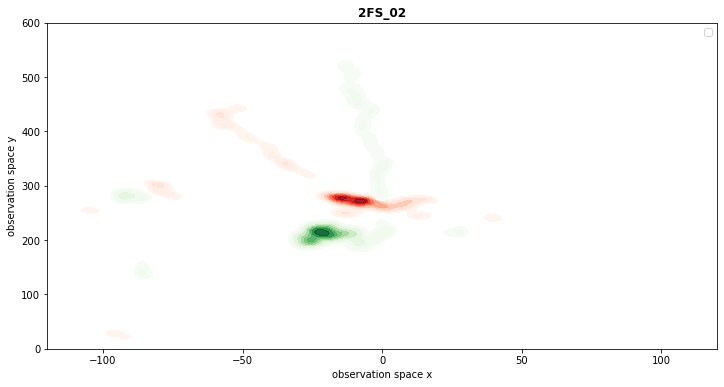

In [83]:
code = "2FS_02"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([0, 600])

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


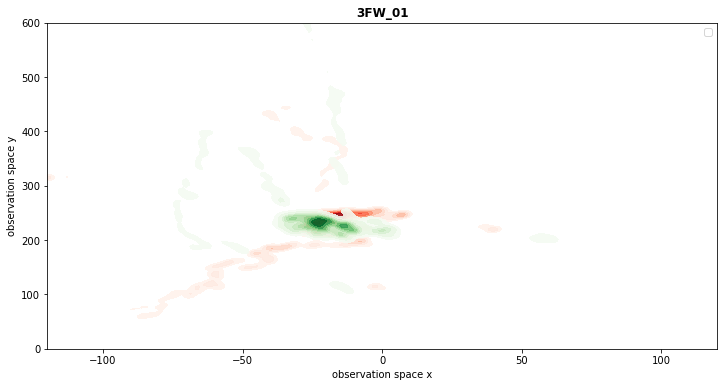

In [82]:
code = "3FW_01"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([0, 600])

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


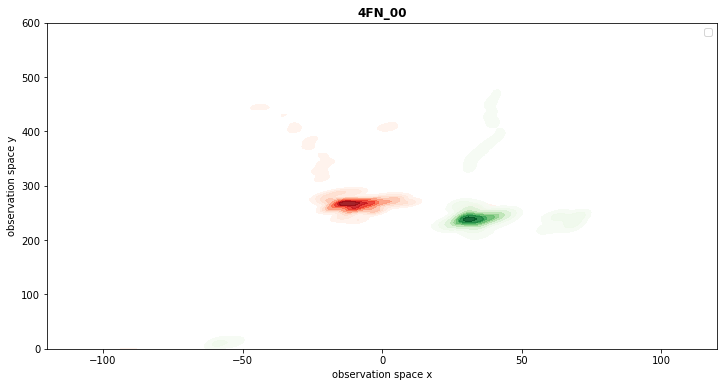

In [81]:
code = "4FN_00"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([0, 600])

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

ax.legend()

For all three trials the heatmaps of both individual eyes converge on x = 0 and y = 250. This position is definitely inhabited by the spaceship. We will therefore use [0, 250] as point of spaceship for further analysis of the experiment.

# Finding runs that can be compared (same trial, same drift, different input_noise, but no crash)

In [86]:
code="pilot4"

N_run = 43

levels = []
crashs = []
drifts = []
input_noise_magnitudes = []

for n_run in np.arange(N_run+1):
    input_data = pd.read_csv(f'input_data/{code}_output_{n_run:0>2}.csv', index_col=False)
    input_data = pre_process_input_data(input_data)
    levels.append(input_data.iloc[-1].trial)
    crashs.append(input_data.iloc[-1].collision)
    drifts.append(input_data.iloc[-1].drift_enabled)
    input_noise_magnitudes.append(input_data.iloc[-1].input_noise_magnitude)
    
trial_config = pd.DataFrame(columns=['level', 'crash', 'drift', 'input_noise'])
trial_config.level = levels
trial_config.crash = crashs
trial_config.drift = drifts
trial_config.input_noise = input_noise_magnitudes

trial_config    

,level,crash,drift,input_noise
0,3,False,True,strong
1,4,False,True,strong
2,6,True,True,weak
3,6,False,False,NaN
4,5,False,True,NaN
5,3,False,True,NaN
6,2,False,True,strong
7,6,True,True,strong
8,6,True,True,NaN
9,1,False,False,weak


In [97]:
trial_config_no_crashs = trial_config[trial_config.crash == False]

grouped = trial_config_no_crashs.groupby(["level", "drift"])
for name_of_the_group, group in grouped:
    print(name_of_the_group)
    print(group)

(1, False)
    level  crash  drift input_noise
9       1  False  False        weak
13      1  False  False         NaN
24      1  False  False      strong
(1, True)
    level  crash  drift input_noise
26      1  False   True        weak
28      1  False   True         NaN
29      1  False   True      strong
(2, False)
    level  crash  drift input_noise
12      2  False  False      strong
21      2  False  False         NaN
34      2  False  False        weak
(2, True)
    level  crash  drift input_noise
6       2  False   True      strong
10      2  False   True         NaN
16      2  False   True        weak
(3, False)
    level  crash  drift input_noise
14      3  False  False        weak
25      3  False  False         NaN
39      3  False  False      strong
(3, True)
    level  crash  drift input_noise
0       3  False   True      strong
5       3  False   True         NaN
33      3  False   True        weak
(4, False)
    level  crash  drift input_noise
11      4  False  False   

In [98]:
trial_config_combinations = [[9, 13, 24], [26, 28, 29], [12, 21, 34], [6, 10, 16], [14, 25, 39], [0, 5, 33], [11, 19, 40], [1, 20, 22], [18, 35, 42], [4, 15, 43], [3, 37, 42], [31, 38]]